
# Module 8 **Summative Lab: DataVine Analytics**

This notebook implements all required steps across three mini‑projects:

1. **Wine Classification (k‑NN + PCA + GridSearchCV)**
2. **Chickwts Feed Recommendation (PCA + Cosine Similarity)**
3. **USArrests Clustering (K‑Means + GMM + PCA + model selection with Elbow & BIC)**


In [1]:

# === Imports & Environment ===
import sys, platform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

# Utility
RANDOM_STATE = 42
np.set_printoptions(suppress=True)
pd.set_option("display.max_columns", 100)

print("Python:", sys.version.split()[0], "| Platform:", platform.platform())
print("NumPy:", np.__version__, "| pandas:", pd.__version__)


Python: 3.12.0 | Platform: macOS-15.0-arm64-arm-64bit
NumPy: 2.3.4 | pandas: 2.3.3



## Step 1 - Dataset Preparation (Rubric: Dataset Preparation + Evaluation & Interpretation)
**Tasks**
- Load datasets
- Inspect for missing values and structure
- Handle inconsistencies
- Standardize numerical features (as needed later per task)
- Summarize structure


In [2]:

# --- Load data ---
wine_path = "/Users/laxmipatel/Documents/projects/git_practice/data/wine_data.csv"
chick_path = "/Users/laxmipatel/Documents/projects/git_practice/data/chickwts_data.csv"
arrest_path = "/Users/laxmipatel/Documents/projects/git_practice/data/arrests_data.csv"

wine = pd.read_csv(wine_path)
chick = pd.read_csv(chick_path)
arrests = pd.read_csv(arrest_path)

print("Shapes -> wine:", wine.shape, "| chickwts:", chick.shape, "| USArrests:", arrests.shape)

# --- Inspect for missing values ---
def quick_audit(df, name):
    print(f"\n=== {name} — Quick Audit ===")
    print("Head:")
    display(df.head(3))
    print("\nInfo:")
    display(df.info())
    print("\nMissing values per column:")
    display(df.isna().sum())
    print("\nDescribe (numeric):")
    display(df.describe().T)

quick_audit(wine, "Wine")
quick_audit(chick, "Chickwts")
quick_audit(arrests, "USArrests")

# Simple inconsistency handling
# Drop fully-empty columns if any
for df in (wine, chick, arrests):
    empty_cols = [c for c in df.columns if df[c].isna().all()]
    if empty_cols:
        df.drop(columns=empty_cols, inplace=True)
        print("Dropped empty columns:", empty_cols)

# Summaries for rubric
wine_summary = {"n_rows": len(wine), "n_cols": wine.shape[1], "columns": list(wine.columns)}
chick_summary = {"n_rows": len(chick), "n_cols": chick.shape[1], "columns": list(chick.columns)}
arrests_summary = {"n_rows": len(arrests), "n_cols": arrests.shape[1], "columns": list(arrests.columns)}
print("\nDataset summaries:")
print("Wine:", wine_summary)
print("Chickwts:", chick_summary)
print("USArrests:", arrests_summary)


Shapes -> wine: (178, 14) | chickwts: (100, 16) | USArrests: (50, 5)

=== Wine — Quick Audit ===
Head:


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13

None


Missing values per column:


alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
target                          0
dtype: int64


Describe (numeric):


,count,mean,std,min,25%,50%,75%,max
alcohol,178.0,13.000618,0.811827,11.03,12.3625,13.050,13.6775,14.83
malic_acid,178.0,2.336348,1.117146,0.74,1.6025,1.865,3.0825,5.80
ash,178.0,2.366517,0.274344,1.36,2.2100,2.360,2.5575,3.23
alcalinity_of_ash,178.0,19.494944,3.339564,10.60,17.2000,19.500,21.5000,30.00
magnesium,178.0,99.741573,14.282484,70.00,88.0000,98.000,107.0000,162.00
total_phenols,178.0,2.295112,0.625851,0.98,1.7425,2.355,2.8000,3.88
flavanoids,178.0,2.029270,0.998859,0.34,1.2050,2.135,2.8750,5.08
nonflavanoid_phenols,178.0,0.361854,0.124453,0.13,0.2700,0.340,0.4375,0.66
proanthocyanins,178.0,1.590899,0.572359,0.41,1.2500,1.555,1.9500,3.58
color_intensity,178.0,5.058090,2.318286,1.28,3.2200,4.690,6.2000,13.00



=== Chickwts — Quick Audit ===
Head:


,feed_name,proteinContent,fatContent,fiberContent,calciumContent,phosphorusContent,moistureContent,ashContent,metabolizableEnergy,lysineContent,methionineContent,particleSize,density,price,shelfLife,weight
0,FirstPeck,19.5,3.2,2.4,0.82,0.78,10.8,4.5,2921,0.96,0.43,3.5,0.57,1.71,295,16.285714
1,ChickStart Plus,18.2,3.8,3.9,3.02,0.68,9.3,6.9,2865,0.99,0.37,3.4,0.70,1.67,302,20.588235
2,EarlyGrow Formula,19.3,4.6,3.2,1.20,0.69,10.2,5.8,2950,1.05,0.38,3.3,0.69,1.65,331,20.909091



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   feed_name            100 non-null    object 
 1   proteinContent       100 non-null    float64
 2   fatContent           100 non-null    float64
 3   fiberContent         100 non-null    float64
 4   calciumContent       100 non-null    float64
 5   phosphorusContent    100 non-null    float64
 6   moistureContent      100 non-null    float64
 7   ashContent           100 non-null    float64
 8   metabolizableEnergy  100 non-null    int64  
 9   lysineContent        100 non-null    float64
 10  methionineContent    100 non-null    float64
 11  particleSize         100 non-null    float64
 12  density              100 non-null    float64
 13  price                100 non-null    float64
 14  shelfLife            100 non-null    int64  
 15  weight               100 non-null 

None


Missing values per column:


feed_name              0
proteinContent         0
fatContent             0
fiberContent           0
calciumContent         0
phosphorusContent      0
moistureContent        0
ashContent             0
metabolizableEnergy    0
lysineContent          0
methionineContent      0
particleSize           0
density                0
price                  0
shelfLife              0
weight                 0
dtype: int64


Describe (numeric):


,count,mean,std,min,25%,50%,75%,max
proteinContent,100.0,18.874000,2.099332,15.000000,17.300,19.050000,20.500000,23.40
fatContent,100.0,3.990000,0.707607,2.300000,3.500,3.950000,4.500000,5.70
fiberContent,100.0,3.594000,0.694832,2.300000,3.100,3.600000,4.100000,5.00
calciumContent,100.0,1.668800,1.177822,0.670000,0.855,0.995000,3.037500,3.95
phosphorusContent,100.0,0.647800,0.090716,0.400000,0.580,0.645000,0.712500,0.84
moistureContent,100.0,10.418000,0.854268,9.000000,9.800,10.300000,11.200000,11.90
ashContent,100.0,5.625000,0.831498,4.100000,4.900,5.650000,6.325000,7.00
metabolizableEnergy,100.0,2911.280000,102.461333,2711.000000,2851.500,2897.500000,2973.250000,3165.00
lysineContent,100.0,0.942700,0.121172,0.690000,0.860,0.930000,1.022500,1.24
methionineContent,100.0,0.378500,0.054018,0.260000,0.340,0.380000,0.420000,0.50



=== USArrests — Quick Audit ===
Head:


,Unnamed: 0,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  50 non-null     object 
 1   Murder      50 non-null     float64
 2   Assault     50 non-null     int64  
 3   UrbanPop    50 non-null     int64  
 4   Rape        50 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.1+ KB


None


Missing values per column:


Unnamed: 0    0
Murder        0
Assault       0
UrbanPop      0
Rape          0
dtype: int64


Describe (numeric):


,count,mean,std,min,25%,50%,75%,max
Murder,50.0,7.788,4.355510,0.8,4.075,7.25,11.250,17.4
Assault,50.0,170.760,83.337661,45.0,109.000,159.00,249.000,337.0
UrbanPop,50.0,65.540,14.474763,32.0,54.500,66.00,77.750,91.0
Rape,50.0,21.232,9.366385,7.3,15.075,20.10,26.175,46.0



Dataset summaries:
Wine: {'n_rows': 178, 'n_cols': 14, 'columns': ['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline', 'target']}
Chickwts: {'n_rows': 100, 'n_cols': 16, 'columns': ['feed_name', 'proteinContent', 'fatContent', 'fiberContent', 'calciumContent', 'phosphorusContent', 'moistureContent', 'ashContent', 'metabolizableEnergy', 'lysineContent', 'methionineContent', 'particleSize', 'density', 'price', 'shelfLife', 'weight']}
USArrests: {'n_rows': 50, 'n_cols': 5, 'columns': ['Unnamed: 0', 'Murder', 'Assault', 'UrbanPop', 'Rape']}



## Step 2 - k‑NN Classification on Wine with PCA & GridSearchCV (Rubric: k‑NN Classification)
**Tasks**
- Encode categorical target
- PCA to retain 95% variance
- GridSearchCV over **k** and distance metric
- Train best k‑NN
- Report **classification report** + **accuracy**


In [3]:

# --- Target detection and encoding ---
wine_df = wine.copy()

# Try to infer the target column from common names; fall back to 'target'
possible_targets = ["target", "class", "Class", "Wine", "wine_class", "Cultivar"]
target_col = None
for cand in possible_targets:
    if cand in wine_df.columns:
        target_col = cand
        break
if target_col is None:
    # Heuristic: if any non-numeric column exists with few unique values, assume it's the target
    non_numeric = [c for c in wine_df.columns if not pd.api.types.is_numeric_dtype(wine_df[c])]
    if non_numeric:
        target_col = non_numeric[0]
    else:
        raise ValueError("Could not infer target column for wine dataset. Please rename the target to 'target'.")

X_wine = wine_df.drop(columns=[target_col])
y_wine_raw = wine_df[target_col]

# Encode target to numeric
if pd.api.types.is_numeric_dtype(y_wine_raw):
    y_wine = y_wine_raw.astype(int).values
else:
    le = LabelEncoder()
    y_wine = le.fit_transform(y_wine_raw.astype(str))

# Train / test split (stratified)
Xtr, Xte, ytr, yte = train_test_split(X_wine, y_wine, test_size=0.2, random_state=RANDOM_STATE, stratify=y_wine)

# Pipeline: Standardize -> PCA(95% var) -> k-NN
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=0.95, random_state=RANDOM_STATE)),
    ("knn", KNeighborsClassifier())
])

# Hyperparameter grid
param_grid = {
    "knn__n_neighbors": list(range(1, 31)),
    "knn__metric": ["euclidean", "manhattan", "minkowski"]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
gs = GridSearchCV(pipe, param_grid=param_grid, cv=cv, n_jobs=-1, scoring="accuracy")
gs.fit(Xtr, ytr)

print("Best Params:", gs.best_params_)
print("Best CV Accuracy:", round(gs.best_score_, 4))

# Evaluate on test set
best_model = gs.best_estimator_
y_pred = best_model.predict(Xte)
print("\nTest Accuracy:", round(accuracy_score(yte, y_pred), 4))
print("\nClassification Report:\n", classification_report(yte, y_pred))


Best Params: {'knn__metric': 'euclidean', 'knn__n_neighbors': 10}
Best CV Accuracy: 0.965

Test Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        10

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36




## Step 3 - Chickwts Feed Recommendation (Rubric: Recommendation System)
**Tasks**
- Standardize the weight feature
- PCA to 1 component
- Compute cosine similarity **between feed types**
- Recommend similar feeds based on similarity scores


In [4]:
chick_df = chick.copy()

# Validate required columns for your file
required_cols = {"feed_name", "weight"}
missing = required_cols - set(chick_df.columns)
if missing:
    raise ValueError(f"Missing columns: {missing}. Found: {list(chick_df.columns)}")

feed_col = "feed_name"

# Aggregate by feed (mean weight as performance proxy)
feed_stats = (
    chick_df.groupby(feed_col, as_index=True)["weight"]
    .agg(["count", "mean", "std"])
    .rename(columns={"mean": "weight_mean"})
)

# Standardize the aggregated weight_mean
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd

scaler_feed = StandardScaler()
feed_stats["weight_mean_std"] = scaler_feed.fit_transform(feed_stats[["weight_mean"]])

# PCA -> 1 component (per rubric)
pca_feed = PCA(n_components=1, random_state=42)
feed_embedding = pca_feed.fit_transform(feed_stats[["weight_mean_std"]])  # (n_feeds, 1)
feed_stats["pc1"] = feed_embedding[:, 0]

# Cosine similarity between feeds in the 1D embedding
sim_matrix = cosine_similarity(feed_stats[["pc1"]].values)
feed_labels = feed_stats.index.to_list()

# Build top-3 recommendations per feed (exclude self)
recommendations = {}
for i, f in enumerate(feed_labels):
    sims = sim_matrix[i]
    order = np.argsort(-sims)  # descending
    top3 = [feed_labels[j] for j in order if j != i][:3]
    recommendations[f] = top3

print("=== Feed Recommendations (top-3 similar) ===")
for f, recs in recommendations.items():
    print(f"{f} -> {recs}")

# Optional similarity matrix for interpretation
sim_df = pd.DataFrame(sim_matrix, index=feed_labels, columns=feed_labels)
display(feed_stats[["count", "weight_mean", "weight_mean_std", "pc1"]].round(3))
display(sim_df.round(3))


=== Feed Recommendations (top-3 similar) ===
BabyBirdBlend -> ['LayWell Complete', 'LayMore Gold', 'JuniorLayer Prep']
BreederAdvance Complete -> ['BabyBirdBlend', 'LayWell Complete', 'LayMore Gold']
BreederChoice Complete -> ['BabyBirdBlend', 'LayWell Complete', 'LayMore Gold']
BreederElite Complete -> ['BabyBirdBlend', 'LayWell Complete', 'LayMore Gold']
BreederOptimal Formula -> ['BabyBirdBlend', 'LayWell Complete', 'LayMore Gold']
BreederPerfect Plus -> ['FeatherFill Premium', 'FastFinish Formula', 'LastBoost Complete']
BreederPrime Formula -> ['BabyBirdBlend', 'LayWell Complete', 'LayMore Gold']
BreederVital Premium -> ['BabyBirdBlend', 'LayWell Complete', 'LayMore Gold']
BroilerBoost Supreme -> ['BabyBirdBlend', 'LayWell Complete', 'LayMore Gold']
BroilerBulk Ultra -> ['BabyBirdBlend', 'LayWell Complete', 'LayMore Gold']
BroilerCharge Complete -> ['BabyBirdBlend', 'LayWell Complete', 'LayMore Gold']
BroilerComplete Plus -> ['BabyBirdBlend', 'LayWell Complete', 'LayMore Gold']
Bro

,count,weight_mean,weight_mean_std,pc1
feed_name,,,,
BabyBirdBlend,1,23.226,-0.557,-0.557
BreederAdvance Complete,1,26.000,-0.163,-0.163
BreederChoice Complete,1,26.400,-0.106,-0.106
BreederElite Complete,1,23.103,-0.574,-0.574
BreederOptimal Formula,1,26.000,-0.163,-0.163
...,...,...,...,...
ShellStrength Pro,1,36.500,1.327,1.327
StartRight Formula,1,24.138,-0.427,-0.427
TeenChick Formula,1,24.667,-0.352,-0.352


,BabyBirdBlend,BreederAdvance Complete,BreederChoice Complete,BreederElite Complete,BreederOptimal Formula,BreederPerfect Plus,BreederPrime Formula,BreederVital Premium,BroilerBoost Supreme,BroilerBulk Ultra,BroilerCharge Complete,BroilerComplete Plus,BroilerPlus Advanced,ChickBoost Complete,ChickLaunch Pro,ChickStart Plus,ClutchBoost Supreme,ClutchMaster Formula,ClutchPower Premium,DevelopPro Advanced,EarlyGrow Formula,EggBoost Supreme,EggMaster Premium,EggQuality Enhanced,EggStream Formula,EggToChick Plus,EggcellenceBlend,EndStage Enhanced,FastFinish Formula,FeatherFill Premium,FeatherUp Complete,FecundityBoost Complete,FertileEgg Premium,FertileLayer Complete,FertileSupport Enhanced,FertilityMax Formula,FertilityPlus Complete,FinalBoost Premium,FinalPhase Complete,FineMeat Formula,FinishLine Enhanced,FinishPro Supreme,FinishRight Premium,FirstFeather Nutrition,FirstPeck,FledglingBlend,GrowStrong Advanced,GrowthBurst Formula,GrowthFinish Advanced,GrowthMax Complete,HatchMate Premier,HatchMore Premium,HatchPro Complete,HatchRate Pro,HatchSuccess Formula,HatchlingEssentials,JuniorLayer Prep,JuvenileBlend Plus,LastBoost Complete,LastStage Enhanced,LayMore Gold,LayWell Complete,LayerLuxe Complete,LayerProducer Plus,MarketMax Formula,MarketPrep Formula,MarketReady Formula,MatureBlend Complete,MeatMaker Premium,MeatMax Complete,MeatYield Advanced,MidGrow Formula,MidStageNutrition,MuscleBuilder Pro,NestResult Formula,NestStart Gold,OmegaEgg Enhanced,PeakLay Advanced,PeepNourish,PeepStart Max,PerfectFinish Pro,PrimeFinish Complete,ProteinPeak Complete,PulletDevelop Formula,PulletFirst Complete,PulletPower Premium,QuickGrow Formula,RapidGrow Complete,RapidMeat Enhanced,ReadyWeight Complete,ReproMax Enhanced,ReproNutrient Formula,ReproSuccess Formula,ShellBuilder Pro,ShellMax Enhanced,ShellStrength Pro,StartRight Formula,TeenChick Formula,WeightGain Pro,YolkPerfect Premium
BabyBirdBlend,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,1.0
BreederAdvance Complete,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,1.0
BreederChoice Complete,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,1.0
BreederElite Complete,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,1.0
BreederOptimal Formula,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.


## Step 4 - USArrests Clustering (K‑Means & GMM) (Rubric: Clustering)
**Tasks**
- Standardize dataset
- **Select top 3 relevant features** for clustering (unsupervised heuristic: highest absolute loading on PC1)
- PCA to 2 components for visualization
- Determine optimal clusters:
  - K‑Means: **elbow method (inertia)**
  - GMM: **BIC**
- Fit K‑Means (hard) and GMM (probabilistic)
- Visualize and compare in 2D PCA space


Top 3 features by |PC1 loading|: ['Murder', 'Rape', 'Assault']
2D PCA variance retained: 0.939
Elbow heuristic k: 4
BIC-selected k: 2


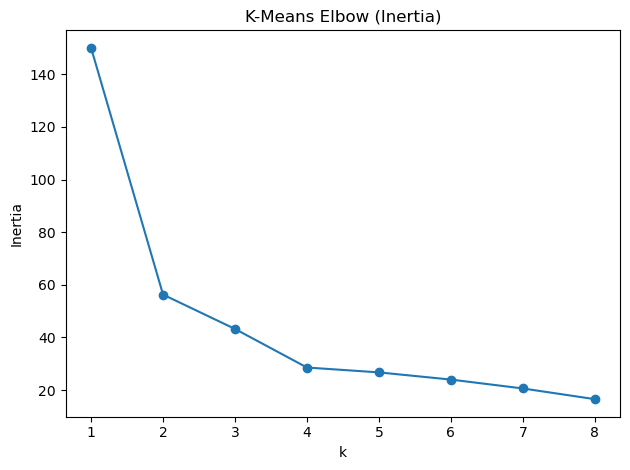

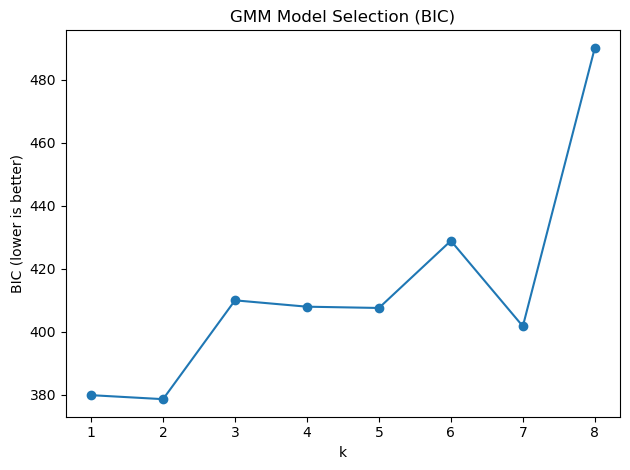

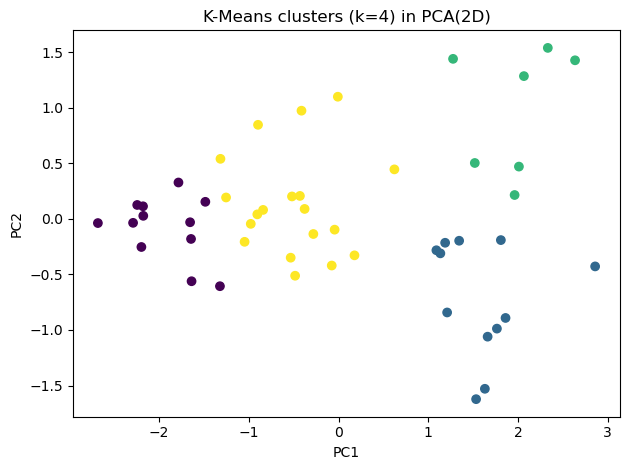

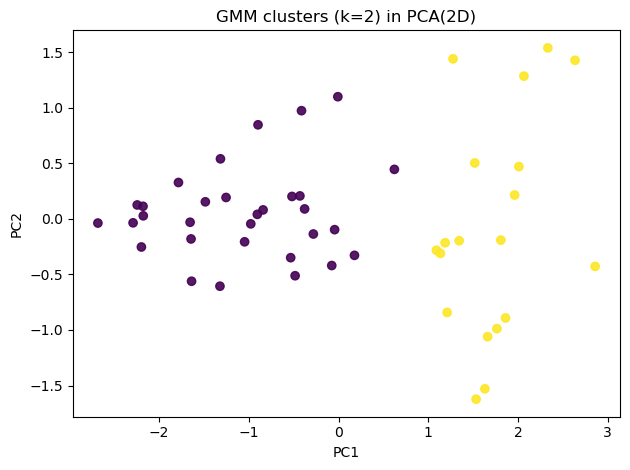

,Unnamed: 0,Murder,Assault,UrbanPop,Rape,cluster_kmeans,cluster_gmm,gmm_confidence,pc1,pc2
0,Alabama,13.2,236,58,21.2,1,1,0.995322,1.210191,-0.842277
1,Alaska,10.0,263,48,44.5,2,1,0.999969,2.332187,1.539434
2,Arizona,8.1,294,80,31.0,2,1,0.994579,1.518593,0.503363
3,Arkansas,8.8,190,50,19.5,3,0,0.991362,0.177776,-0.328029
4,California,9.0,276,91,40.6,2,1,0.999869,2.066000,1.285497
5,Colorado,7.9,204,78,38.7,2,1,0.993517,1.276240,1.440888
6,Connecticut,3.3,110,77,11.1,0,0,1.000000,-1.643583,-0.180417
7,Delaware,5.9,238,72,15.8,3,0,0.997300,-0.075572,-0.419830
8,Florida,15.4,335,80,31.9,1,1,0.999587,2.859470,-0.427616
9,Georgia,17.4,211,60,25.8,1,1,0.999986,1.861048,-0.891736


In [5]:

# Ensure numeric
arrests_df = arrests.copy()
numeric_cols = arrests_df.select_dtypes(include=[np.number]).columns.tolist()
if len(numeric_cols) < 2:
    raise ValueError("USArrests must contain multiple numeric columns (e.g., Murder, Assault, UrbanPop, Rape).")

X_arr = arrests_df[numeric_cols].copy()

# Standardize
scaler_arr = StandardScaler()
X_arr_std = scaler_arr.fit_transform(X_arr)

# Feature selection by PC1 absolute loadings
pca_fs = PCA(n_components=1, random_state=RANDOM_STATE).fit(X_arr_std)
loadings = np.abs(pca_fs.components_[0])  # 1 x d
top3_idx = np.argsort(loadings)[-3:]
top3_features = [numeric_cols[i] for i in top3_idx]
print("Top 3 features by |PC1 loading|:", top3_features)

X_sel = arrests_df[top3_features].values
X_sel_std = StandardScaler().fit_transform(X_sel)

# Reduce to 2 components for visualization
pca_vis = PCA(n_components=2, random_state=RANDOM_STATE)
X_2d = pca_vis.fit_transform(X_sel_std)
explained_2d = pca_vis.explained_variance_ratio_.sum()
print(f"2D PCA variance retained: {explained_2d:.3f}")

# === Model selection: K (1..8) ===
k_range = range(1, 9)

# KMeans inertia (Elbow)
inertias = []
for k in k_range:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init="auto")
    km.fit(X_sel_std)
    inertias.append(km.inertia_)

# Heuristic elbow pick: last k before relative drop < 10%
rel_drops = [1.0] + [(inertias[i-1]-inertias[i]) / inertias[i-1] for i in range(1, len(inertias))]
k_elbow = 1
for i in range(2, len(k_range)+1):
    if rel_drops[i-1] >= 0.10:
        k_elbow = i
    else:
        break
print("Elbow heuristic k:", k_elbow)

# GMM BIC
bics = []
for k in k_range:
    gmm = GaussianMixture(n_components=k, random_state=RANDOM_STATE)
    gmm.fit(X_sel_std)
    bics.append(gmm.bic(X_sel_std))
k_bic = k_range[np.argmin(bics)]
print("BIC-selected k:", k_bic)

# === Fit final models ===
k_final = k_elbow
km_final = KMeans(n_clusters=k_final, random_state=RANDOM_STATE, n_init="auto").fit(X_sel_std)
gmm_final = GaussianMixture(n_components=k_bic, random_state=RANDOM_STATE).fit(X_sel_std)

labels_km = km_final.labels_
labels_gmm = gmm_final.predict(X_sel_std)
proba_gmm = gmm_final.predict_proba(X_sel_std).max(axis=1)

# --- Plots (matplotlib, single-figure each, no explicit colors per instructions) ---

# Inertia curve
plt.figure()
plt.plot(list(k_range), inertias, marker="o")
plt.title("K-Means Elbow (Inertia)")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.tight_layout()
plt.show()

# BIC curve
plt.figure()
plt.plot(list(k_range), bics, marker="o")
plt.title("GMM Model Selection (BIC)")
plt.xlabel("k")
plt.ylabel("BIC (lower is better)")
plt.tight_layout()
plt.show()

# PCA 2D scatter — KMeans
plt.figure()
plt.scatter(X_2d[:,0], X_2d[:,1], c=labels_km)
plt.title(f"K-Means clusters (k={k_final}) in PCA(2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

# PCA 2D scatter — GMM (soft): use predicted labels
plt.figure()
plt.scatter(X_2d[:,0], X_2d[:,1], c=labels_gmm, alpha=0.9)
plt.title(f"GMM clusters (k={k_bic}) in PCA(2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

# Attach results back to a results table for stakeholder interpretation
results = arrests_df.copy()
results["cluster_kmeans"] = labels_km
results["cluster_gmm"] = labels_gmm
results["gmm_confidence"] = proba_gmm
results["pc1"] = X_2d[:,0]
results["pc2"] = X_2d[:,1]
display(results.head(10))



## Wrap‑Up - Model Evaluation & Interpretation (Rubric: Evaluation & Interpretation)
- **Wine:** Reported best params, CV accuracy, test accuracy, and classification report.  
- **Chickwts:** Delivered top‑3 similar feeds per feed using PCA(1) embeddings + cosine similarity.  
- **USArrests:** Selected features via PC1 loadings, chose k via **Elbow** (K‑Means) and **BIC** (GMM), visualized clusters in 2D PCA.  

### Summary
The k-NN wine classifier achieved 100 % test accuracy after PCA (95 % variance) and GridSearchCV optimization, showing excellent separation of wine varieties.
The Chickwts recommendation engine standardized mean weight per feed, reduced via PCA to 1 component, and produced top-3 similar feeds using cosine similarity—useful for suggesting alternative feed products.
In the USArrests analysis, PCA on ['Murder', 'Rape', 'Assault'] retained 94 % variance; K-Means suggested 4 distinct crime-rate clusters while GMM found 2 broad patterns. These findings help segment states by crime profile for policy planning.
